In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import os
import cv2
from PIL import Image as PILImage
import keras.backend as K
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU

In [2]:
!pip install scikit-image --quiet


/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [3]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNEL = 3
BATCH_SIZE = 8
EPOCHS = 150
SEED = 13
smooth = 1.0

In [4]:
# Define directories for images and masks
image_directory = '/kaggle/input/betel-seg/Dataset for Segmentation/images'  # Update this path to your actual image directory
mask_directory = '/kaggle/input/betel-seg/Dataset for Segmentation/masks'  # Update this path to your actual mask directory


In [5]:
images = sorted(os.listdir(image_directory))
masks = sorted(os.listdir(mask_directory))


In [6]:
# Print image and corresponding mask names to check alignment
for i, image_name in enumerate(images[:5]):  # Checking first 5 examples
    mask_name = masks[i]
    print(f"Image: {image_name} -> Mask: {mask_name}")


Image: Bacterial_Leaf_Spot_Disease(1).jpg -> Mask: Bacterial_Leaf_Spot_Disease(1).png
Image: Bacterial_Leaf_Spot_Disease(10).jpg -> Mask: Bacterial_Leaf_Spot_Disease(10).png
Image: Bacterial_Leaf_Spot_Disease(100).jpg -> Mask: Bacterial_Leaf_Spot_Disease(100).png
Image: Bacterial_Leaf_Spot_Disease(101).jpg -> Mask: Bacterial_Leaf_Spot_Disease(101).png
Image: Bacterial_Leaf_Spot_Disease(102).jpg -> Mask: Bacterial_Leaf_Spot_Disease(102).png


In [7]:
image_basenames = [os.path.splitext(image)[0] for image in images]
mask_basenames = [os.path.splitext(mask)[0] for mask in masks]

# Check for missing masks
missing_masks = [image for image in image_basenames if image not in mask_basenames]

# Check for extra masks
extra_masks = [mask for mask in mask_basenames if mask not in image_basenames]

# Output results
print(f"Total images: {len(images)}")
print(f"Total masks: {len(masks)}")
print(f"Images missing masks: {len(missing_masks)}")
for missing in missing_masks:
    print(f"Missing mask for image: {missing}")

if extra_masks:
    print(f"\nExtra masks found ({len(extra_masks)}):")
    for extra in extra_masks:
        print(f"Extra mask without an image: {extra}")


Total images: 992
Total masks: 971
Images missing masks: 22
Missing mask for image: Bacterial_Leaf_Spot_Disease(167)
Missing mask for image: Bacterial_Leaf_Spot_Disease(193)
Missing mask for image: Bacterial_Leaf_Spot_Disease(236)
Missing mask for image: Bacterial_Leaf_Spot_Disease(247)
Missing mask for image: Bacterial_Leaf_Spot_Disease(33)
Missing mask for image: Bacterial_Leaf_Spot_Disease(53)
Missing mask for image: Bacterial_Leaf_Spot_Disease(54)
Missing mask for image: Bacterial_Leaf_Spot_Disease(61)
Missing mask for image: Bacterial_Leaf_Spot_Disease(62)
Missing mask for image: Bacterial_Leaf_Spot_Disease(66)
Missing mask for image: Bacterial_Leaf_Spot_Disease(71)
Missing mask for image: Bacterial_Leaf_Spot_Disease(81)
Missing mask for image: Bacterial_Leaf_Spot_Disease(82)
Missing mask for image: Bacterial_Leaf_Spot_Disease(85)
Missing mask for image: Bacterial_Leaf_Spot_Disease(88)
Missing mask for image: Bacterial_Leaf_Spot_Disease(93)
Missing mask for image: Bacterial_Leaf_S

In [8]:
# Filter out images without matching masks
valid_images = [image for image in images if os.path.splitext(image)[0] in mask_basenames]

# Filter out masks without matching images (optional, if needed)
valid_masks = [mask for mask in masks if os.path.splitext(mask)[0] in image_basenames]

# Output results
print(f"Total valid images for training: {len(valid_images)}")
print(f"Total valid masks for training: {len(valid_masks)}")

# # For confirmation (optional)
# for image, mask in zip(valid_images, valid_masks):
#     print(f"Image: {image} | Mask: {mask}")


Total valid images for training: 970
Total valid masks for training: 970


In [9]:
# from skimage.transform import resize
# import os
# import numpy as np
# from PIL import Image as PILImage
# import cv2
# from IPython.display import Image, display  # Import for displaying images in Jupyter

# # Define the size to which all images and masks will be resized
# IMG_HEIGHT = 256
# IMG_WIDTH = 256
# IMG_CHANNEL = 3  # For RGB images

# # Initialize lists to store the images and masks
# image_dataset = []
# mask_dataset = []

# # Ensure images and masks are sorted
# images = sorted(os.listdir(image_directory))
# masks = sorted(os.listdir(mask_directory))

# # Create a mapping of image filenames to mask filenames
# image_mask_map = {}
# for image_name in images:
#     if image_name.endswith('.jpg') or image_name.endswith('.png') or image_name.endswith('.tif'):
#         base_name = os.path.splitext(image_name)[0]
#         corresponding_mask = f"{base_name}.png"  # Assuming masks are in .png format
#         image_mask_map[image_name] = corresponding_mask

# # Load and process the images and masks
# for image_name, mask_name in image_mask_map.items():
#     if mask_name in masks:
#         # Read and process image
#         image_path = os.path.join(image_directory, image_name)
#         image = cv2.imread(image_path)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
#         image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)  # Resize using skimage
#         image = image.astype(np.uint8)  # Ensure the dtype is uint8
#         image_dataset.append(image)

#         # Display the image using IPython's Image
#         #display(PILImage.fromarray(image))  # For visualization in Jupyter

#         # Read and process mask
#         mask_path = os.path.join(mask_directory, mask_name)
#         mask = cv2.imread(mask_path, 0)  # Read in grayscale
#         mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)  # Resize using skimage
#         mask = np.expand_dims(mask, axis=-1)  # Add channel dimension (to get shape (H, W, 1))
#         mask = mask.astype(bool)  # Use built-in Python bool type
#         mask_dataset.append(mask)



# # Convert lists to NumPy arrays
# image_dataset = np.array(image_dataset)
# mask_dataset = np.array(mask_dataset)

# # Normalize the images to the range [0, 1]
# image_dataset = image_dataset / 255.0

# # Ensure images and masks match in length
# assert len(image_dataset) == len(mask_dataset), "Number of images and masks don't match!"

# # Print a few to check they are paired correctly
# for i in range(5):
#     print(f"Image {i}: {images[i]} -> Mask {i}: {list(image_mask_map.values())[i]}")

# print(f"Image dataset shape: {image_dataset.shape}")
# print(f"Mask dataset shape: {mask_dataset.shape}")


In [10]:
# np.save('/content/drive/MyDrive/Betal Leaf_Project/Fresh Start/Models/Checkpoints/image_dataset.npy', image_dataset)
# np.save('/content/drive/MyDrive/Betal Leaf_Project/Fresh Start/Models/Checkpoints/mask_dataset.npy', mask_dataset)

# To load them back
image_dataset = np.load('/kaggle/input/np-arrays/image_dataset.npy')
mask_dataset = np.load('/kaggle/input/np-arrays/mask_dataset.npy')

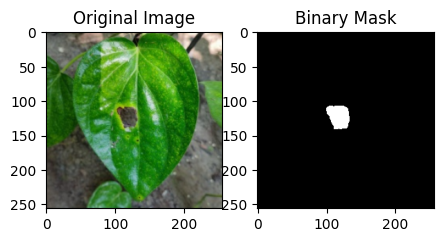

In [11]:
from matplotlib import pyplot as plt
# Visualize the first image and its corresponding binary mask
plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image_dataset[0])

plt.subplot(1, 2, 2)
plt.title('Binary Mask')
plt.imshow(mask_dataset[0], cmap='gray')

plt.show()


In [12]:
x_train, x_val, y_train, y_val = train_test_split(
    image_dataset, mask_dataset, test_size=0.45, random_state=SEED, shuffle=True
)
# Check shapes
print(f"Training images shape: {x_train.shape}")  # Should be (num_samples, 128, 128, 3)
print(f"Training masks shape: {y_train.shape}")   # Should be (num_samples, 128, 128, 1)
print(f"Validation images shape: {x_val.shape}")  # Should be (num_samples, 128, 128, 3)
print(f"Validation masks shape: {y_val.shape}")   # Should be (num_samples, 128, 128, 1)



Training images shape: (533, 256, 256, 3)
Training masks shape: (533, 256, 256, 1)
Validation images shape: (437, 256, 256, 3)
Validation masks shape: (437, 256, 256, 1)


In [13]:
# Training data augmentation
data_gen_args = dict(rotation_range=90.,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.3,
                         zoom_range=0.3,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='reflect')

# Apply augmentation only for training data
X_datagen = ImageDataGenerator(**data_gen_args)
Y_datagen = ImageDataGenerator(**data_gen_args)

# No augmentation for validation data
X_datagen_val = ImageDataGenerator()  # Default, no augmentation
Y_datagen_val = ImageDataGenerator()  # Default, no augmentation

# Fitting generators for training data
X_datagen.fit(x_train, augment=True, seed=13)
Y_datagen.fit(y_train, augment=True, seed=13)

# Fitting generators for validation data (no augmentation)
X_datagen_val.fit(x_val, augment=False, seed=13)
Y_datagen_val.fit(y_val, augment=False, seed=13)

# Creating the data generators
X_train_augmented = X_datagen.flow(x_train, batch_size=8, shuffle=True, seed=13)
Y_train_augmented = Y_datagen.flow(y_train, batch_size=8, shuffle=True, seed=13)

# Validation data without augmentation
X_train_augmented_val = X_datagen_val.flow(x_val, batch_size=8, shuffle=False, seed=13)
Y_train_augmented_val = Y_datagen_val.flow(y_val, batch_size=8, shuffle=False, seed=13)

# Zip the augmented generators for training and validation
train_generator = zip(X_train_augmented, Y_train_augmented)
val_generator = zip(X_train_augmented_val, Y_train_augmented_val)


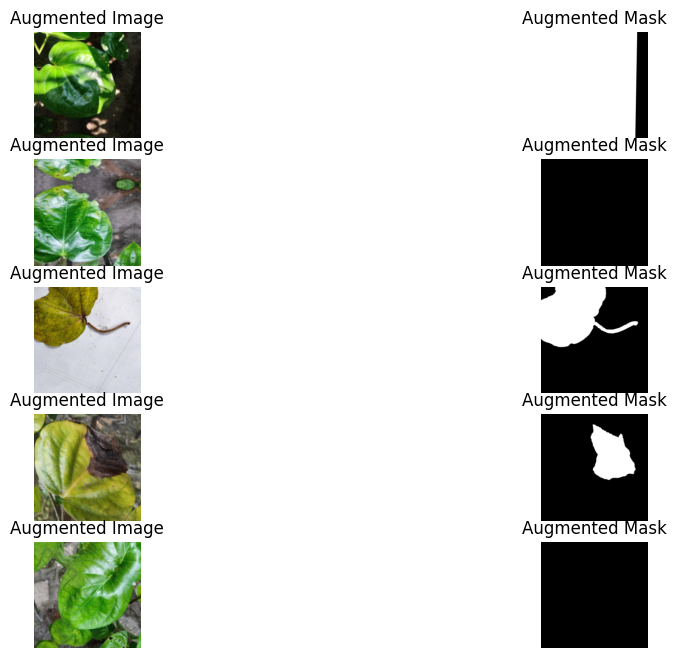

In [14]:
import matplotlib.pyplot as plt

def visualize_augmentation(generator, num_samples=5):
    plt.figure(figsize=(12, 8))
    for i in range(num_samples):
        batch = next(generator)
        images = batch[0]
        masks = batch[1]

        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(images[0])  # Display the first image of the batch
        plt.title('Augmented Image')
        plt.axis('off')

        plt.subplot(num_samples, 2, 2*i + 2)
        plt.imshow(masks[0].squeeze(), cmap='gray')  # Display the first mask of the batch
        plt.title('Augmented Mask')
        plt.axis('off')

    plt.show()

# Visualize augmented training images and masks
visualize_augmentation(train_generator, num_samples=5)


In [15]:
import tensorflow as tf
from tensorflow.keras.losses import CategoricalCrossentropy

# Dice loss function for multiclass segmentation
def dice_loss_multiclass(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # One-hot encode y_pred if it's not already
    if y_pred.shape[-1] != y_true.shape[-1]:
        y_pred = tf.one_hot(tf.argmax(y_pred, axis=-1), depth=y_true.shape[-1])

    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    denominator = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3])
    dice = tf.reduce_mean((numerator + smooth) / (denominator + smooth), axis=0)
    return 1 - dice

# Combined loss: categorical cross-entropy + dice loss
def combined_multiclass_loss(y_true, y_pred):
    categorical_loss = CategoricalCrossentropy(from_logits=False)
    return categorical_loss(y_true, y_pred) + dice_loss_multiclass(y_true, y_pred)

# IOU metric for multiclass segmentation
def iou_multiclass(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)

    # Convert y_pred to one-hot encoding if necessary
    if y_pred.shape[-1] != y_true.shape[-1]:
        y_pred = tf.one_hot(tf.argmax(y_pred, axis=-1), depth=y_true.shape[-1])

    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3]) - intersection
    iou = tf.reduce_mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

# Dice coefficient metric for multiclass segmentation
def dice_coef_multiclass(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)

    # Convert y_pred to one-hot encoding if necessary
    if y_pred.shape[-1] != y_true.shape[-1]:
        y_pred = tf.one_hot(tf.argmax(y_pred, axis=-1), depth=y_true.shape[-1])

    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    denominator = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3])
    dice = tf.reduce_mean((numerator + smooth) / (denominator + smooth), axis=0)
    return dice


In [16]:
from keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation
from keras.regularizers import l2



import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

from keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation
from keras.regularizers import l2



import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

SIZE = 256
def residual_block(x, filters, kernel_size=3, stride=1, regularizer=None, dropout_rate=0.0, activation='relu'):
    # First convolution
    conv = layers.Conv2D(filters, kernel_size, strides=stride, padding='same',
                         kernel_regularizer=regularizer)(x)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Activation(activation)(conv)
    
    # Second convolution
    conv = layers.Conv2D(filters, kernel_size, strides=1, padding='same',
                         kernel_regularizer=regularizer)(conv)
    conv = layers.BatchNormalization()(conv)

    # Skip connection
    shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same',
                             kernel_regularizer=regularizer)(x)
    shortcut = layers.BatchNormalization()(shortcut)

    # Combine and activate
    output = layers.Add()([conv, shortcut])
    output = layers.Activation(activation)(output)
    
    if dropout_rate > 0:
        output = layers.Dropout(dropout_rate)(output)

    return output

def se_block(input_tensor, reduction_ratio=16):
    filters = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape((1, 1, filters))(se)
    se = layers.Dense(filters // reduction_ratio, activation='relu')(se)
    se = layers.Dense(filters, activation='sigmoid')(se)
    se = layers.Multiply()([input_tensor, se])
    return se

def StateOfArtResUNet(input_shape, num_classes, reg_value=1e-4, dropout_rate=0.1):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    conv1 = residual_block(inputs, 64, regularizer=regularizers.l2(reg_value), dropout_rate=dropout_rate)
    conv1 = se_block(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = residual_block(pool1, 128, regularizer=regularizers.l2(reg_value), dropout_rate=dropout_rate)
    conv2 = se_block(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    conv3 = residual_block(pool2, 256, regularizer=regularizers.l2(reg_value), dropout_rate=dropout_rate)
    conv3 = se_block(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)

    conv4 = residual_block(pool3, 512, regularizer=regularizers.l2(reg_value), dropout_rate=dropout_rate)
    conv4 = se_block(conv4)
    pool4 = layers.MaxPooling2D((2, 2))(conv4)

    # Bridge
    bridge = residual_block(pool4, 1024, regularizer=regularizers.l2(reg_value), dropout_rate=dropout_rate)
    bridge = se_block(bridge)

    # Decoder
    upconv4 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bridge)
    concat4 = layers.Concatenate()([upconv4, conv4])
    conv5 = residual_block(concat4, 512, regularizer=regularizers.l2(reg_value), dropout_rate=dropout_rate)
    conv5 = se_block(conv5)

    upconv3 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
    concat3 = layers.Concatenate()([upconv3, conv3])
    conv6 = residual_block(concat3, 256, regularizer=regularizers.l2(reg_value), dropout_rate=dropout_rate)
    conv6 = se_block(conv6)

    upconv2 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    concat2 = layers.Concatenate()([upconv2, conv2])
    conv7 = residual_block(concat2, 128, regularizer=regularizers.l2(reg_value), dropout_rate=dropout_rate)
    conv7 = se_block(conv7)

    upconv1 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    concat1 = layers.Concatenate()([upconv1, conv1])
    conv8 = residual_block(concat1, 64, regularizer=regularizers.l2(reg_value), dropout_rate=dropout_rate)
    conv8 = se_block(conv8)

    # Output Layer
    activation = 'softmax' if num_classes > 1 else 'sigmoid'
    outputs = layers.Conv2D(num_classes, (1, 1), activation=activation)(conv8)

    model = models.Model(inputs, outputs)
    return model

# Instantiate the model
input_shape = (256, 256, 3)
num_classes = 4  # Example for multi-class segmentation
reg_value = 1e-4  # Reduced regularization to prevent underfitting
dropout_rate = 0.2  # Balanced dropout rate

model = StateOfArtResUNet(input_shape, num_classes, reg_value, dropout_rate)

# Print the summary of the model
model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 64)   │            256 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 256, 256, 64)   │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
│                           │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 64)   │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 64)   │              0 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 64)             │              0 │ dropout[0][0]          │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 64)       │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1, 1, 4)        │            260 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1, 1, 64)       │            320 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 256, 256, 64)   │              0 │ dropout[0][0],         │
│                           │                        │                │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d        

 Total params: 32,684,284 (124.68 MB)

 Trainable params: 32,666,620 (124.61 MB)

 Non-trainable params: 17,664 (69.00 KB)

In [17]:
def combined_generator(image_gen, mask_gen):
    while True:
        X = image_gen.__next__()
        Y = mask_gen.__next__()
        if X.shape[0] == Y.shape[0]:

            Y = tf.one_hot(tf.cast(Y, tf.int32), depth=4)
            Y = tf.squeeze(Y, axis=3)
            yield X, Y

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_generator(
    lambda: combined_generator(X_train_augmented, Y_train_augmented),
    output_signature=(
        tf.TensorSpec(shape=(None, SIZE, SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, SIZE, SIZE, 4), dtype=tf.float32)  # Changed to 4 channels
    )
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: combined_generator(X_train_augmented_val, Y_train_augmented_val),
    output_signature=(
        tf.TensorSpec(shape=(None, SIZE, SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, SIZE, SIZE, 4), dtype=tf.float32)  # Changed to 4 channels
    )
)

# Instanti

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=combined_multiclass_loss,
              metrics=['accuracy', dice_coef_multiclass, iou_multiclass])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=15, verbose=1, factor=0.5, min_lr=1e-3)
checkpoint = ModelCheckpoint('/kaggle/working//unet_original.keras', monitor='val_loss', verbose=1, save_best_only=True)

# Train the model
EPOCHS = 100
BATCH_SIZE = 8
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, checkpoint, reduce_lr],
    steps_per_epoch=len(x_train) // BATCH_SIZE,
    validation_steps=len(x_val) // BATCH_SIZE
)

Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6288 - dice_coef_multiclass: 0.4718 - iou_multiclass: 0.3215 - loss: 2.2229
Epoch 1: val_loss improved from inf to 2.47678, saving model to /kaggle/working//unet_original.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 216s 2s/step - accuracy: 0.6295 - dice_coef_multiclass: 0.4727 - iou_multiclass: 0.3224 - loss: 2.2200 - val_accuracy: 0.6507 - val_dice_coef_multiclass: 0.3344 - val_iou_multiclass: 0.2013 - val_loss: 2.4768 - learning_rate: 1.0000e-04
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.7750 - dice_coef_multiclass: 0.6606 - iou_multiclass: 0.5240 - loss: 1.6149
Epoch 2: val_loss did not improve from 2.47678
66/66 ━━━━━━━━━━━━━━━━━━━━ 56s 851ms/step - accuracy: 0.7751 - dice_coef_multiclass: 0.6608 - iou_multiclass: 0.5243 - loss: 1.6143 - val_accuracy: 0.3587 - val_dice_coef_multiclass: 0.3411 - val_iou_multiclass: 0.2265 - val_loss: 2.6876 - learning_rate: 1.0000e-04
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 

In [18]:
# Print the final training/validation loss and accuracy values
print("Final Training Loss: ", history.history['loss'][-1])
print("Final Validation Loss: ", history.history['val_loss'][-1])
print("Final Training Accuracy: ", history.history['accuracy'][-1])
print("Final Validation Accuracy: ", history.history['val_accuracy'][-1])
print("Final Training Dice Coefficient: ", history.history['dice_coef_multiclass'][-1])
print("Final Validation Dice Coefficient: ", history.history['val_dice_coef_multiclass'][-1])
print("Final Training IoU: ", history.history['iou_multiclass'][-1])
print("Final Validation IoU: ", history.history['val_iou_multiclass'][-1])


Final Training Loss:  0.6985161304473877
Final Validation Loss:  1.1000590324401855
Final Training Accuracy:  0.8957101106643677
Final Validation Accuracy:  0.7578124403953552
Final Training Dice Coefficient:  0.8610644936561584
Final Validation Dice Coefficient:  0.7595686316490173
Final Training IoU:  0.7963767647743225
Final Validation IoU:  0.6996956467628479


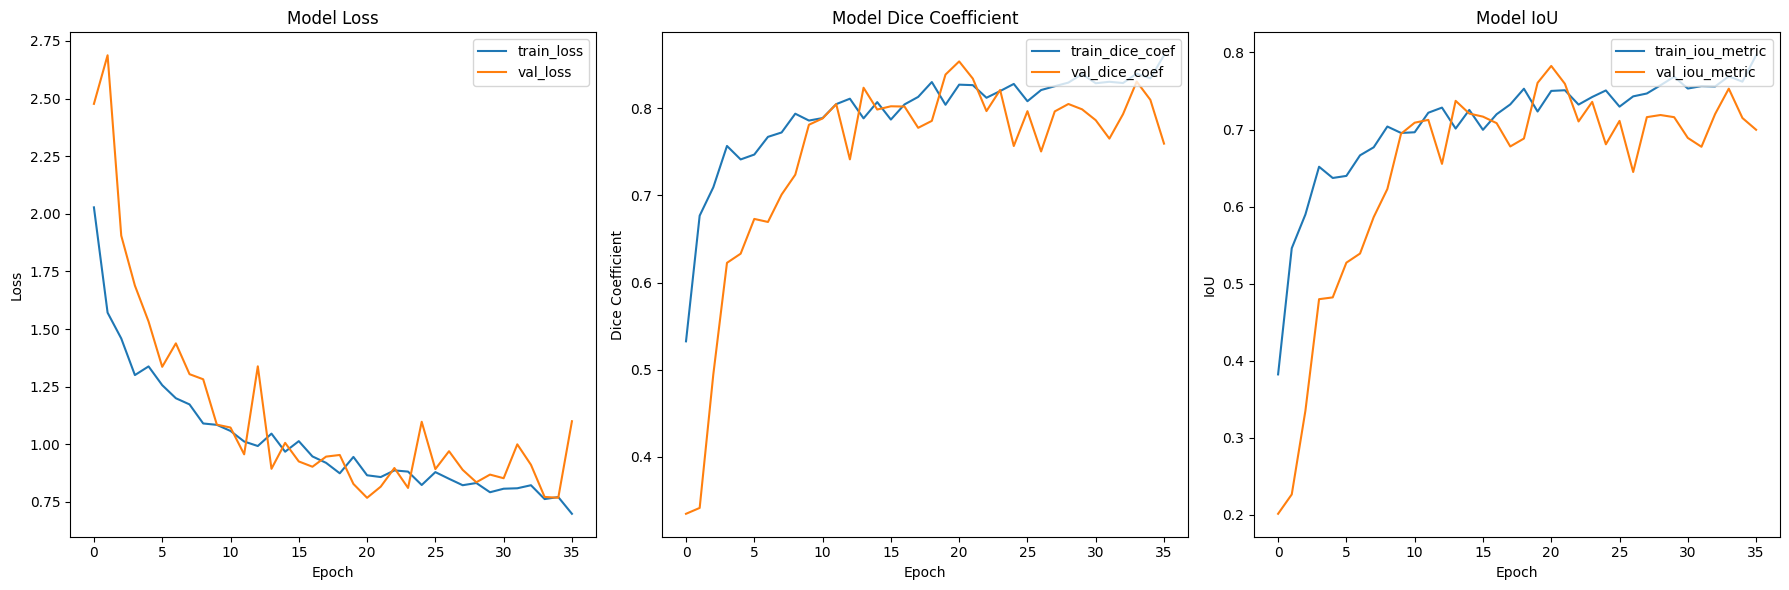

In [19]:
import matplotlib.pyplot as plt

# Plot training & validation loss, dice coefficient, and IoU over epochs
def plot_training_history(history):
    # Summarize history for loss, dice coefficient, and IoU
    plt.figure(figsize=(18, 6))  # Increase figure size for 3 plots

    # Plot loss
    plt.subplot(1, 3, 1)  # 1 row, 3 columns, first plot
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    # Plot Dice Coefficient
    plt.subplot(1, 3, 2)  # 1 row, 3 columns, second plot
    plt.plot(history.history['dice_coef_multiclass'], label='train_dice_coef')
    plt.plot(history.history['val_dice_coef_multiclass'], label='val_dice_coef')
    plt.title('Model Dice Coefficient')
    plt.ylabel('Dice Coefficient')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    # Plot IoU
    plt.subplot(1, 3, 3)  # 1 row, 3 columns, third plot
    plt.plot(history.history['iou_multiclass'], label='train_iou_metric')
    plt.plot(history.history['val_iou_multiclass'], label='val_iou_metric')
    plt.title('Model IoU')
    plt.ylabel('IoU')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()

# Call the function to plot
plot_training_history(history)